In [20]:
%matplotlib inline
from copy import deepcopy
from collections import OrderedDict
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam,lr_scheduler
from torch.utils.data import random_split
import torchvision
from torchvision import transforms,models
import tensorflow as tf


In [21]:
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")

In [22]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

traindata = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainset,valset = random_split(traindata,[42000,8000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64,shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
     

Files already downloaded and verified
Files already downloaded and verified


In [23]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(pretrained=True)
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features,10)
    
    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)
    
model = Model().cuda()
[x for x,y in model.named_children()]

['base', 'drop', 'final']

In [24]:
criterion = nn.CrossEntropyLoss()
param_groups = [
    {'params':model.base.parameters(),'lr':.0001},
    {'params':model.final.parameters(),'lr':.001}
]
optimizer = Adam(param_groups)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
states = {}

In [6]:
%%time
best_val_acc = -1000
best_val_model = None
for epoch in range(10):  
    model.train(True)
    running_loss = 0.0
    running_acc = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(),labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * inputs.size(0)
        out = torch.argmax(outputs.detach(),dim=1)
        assert out.shape==labels.shape
        running_acc += (labels==out).sum().item()
    print(f"Train loss {epoch+1}: {running_loss/len(trainset)},Train Acc:{running_acc*100/len(trainset)}%")
    
    correct = 0
    model.train(False)
    with torch.no_grad():
        for inputs,labels in valloader:
            out = model(inputs.cuda()).cpu()
            out = torch.argmax(out,dim=1)
            acc = (out==labels).sum().item()
            correct += acc
    print(f"Val accuracy:{correct*100/len(valset)}%")
    if correct>best_val_acc:
        best_val_acc = correct
        best_val_model = deepcopy(model.state_dict())
    lr_scheduler.step()
    
print('Finished Training') 

Train loss 1: 0.4969309860865275,Train Acc:82.93333333333334%
Val accuracy:90.675%
Train loss 2: 0.2203578644820622,Train Acc:92.58095238095238%
Val accuracy:93.125%
Train loss 3: 0.18846505874111538,Train Acc:93.54047619047618%
Val accuracy:93.175%
Train loss 4: 0.18235406987581934,Train Acc:93.83571428571429%
Val accuracy:93.25%
Train loss 5: 0.1861965491601399,Train Acc:93.66428571428571%
Val accuracy:93.2%
Train loss 6: 0.1818266436486017,Train Acc:93.79761904761905%
Val accuracy:93.1375%
Train loss 7: 0.18446355011349633,Train Acc:93.77857142857142%
Val accuracy:92.725%
Train loss 8: 0.18525584918260574,Train Acc:93.73809523809524%
Val accuracy:93.0%
Train loss 9: 0.1830836885259265,Train Acc:93.70476190476191%
Val accuracy:93.2375%
Train loss 10: 0.1836809542093958,Train Acc:93.74761904761905%
Val accuracy:93.0125%
Finished Training
CPU times: user 34min 40s, sys: 40.6 s, total: 35min 20s
Wall time: 35min 29s


In [7]:
model

Model(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [8]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = len(testset)
timings=np.zeros((repetitions,1))

In [9]:
%%time
correct = 0
model.load_state_dict(best_val_model)
model.train(False)
with torch.no_grad():
    starter.record()
    for inputs,labels in testloader:
        out = model(inputs.cuda()).cpu()
        out = torch.argmax(out,dim=1)
        acc = (out==labels).sum().item()
    ender.record()
    torch.cuda.synchronize()
    curr_time = starter.elapsed_time(ender)
    timings[epoch] = curr_time
    correct += acc
mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(f'mean prediction latency: {mean_syn}')
print(f"Test accuracy: {correct*100/len(testset)}%")
     

mean prediction latency: 2.29754453125
Test accuracy: 0.16%
CPU times: user 22.2 s, sys: 895 ms, total: 23.1 s
Wall time: 23 s


In [16]:
from google.colab import drive
drive.mount('/content/drive')

import copy
state_dict = torch.load('/content/drive/My Drive/checkpoint.pth', map_location="cpu")
print(state_dict.keys())
model.load_state_dict(state_dict)
model.to(cpu_device)

Mounted at /content/drive
odict_keys(['base.0.weight', 'base.1.weight', 'base.1.bias', 'base.1.running_mean', 'base.1.running_var', 'base.1.num_batches_tracked', 'base.4.0.conv1.weight', 'base.4.0.bn1.weight', 'base.4.0.bn1.bias', 'base.4.0.bn1.running_mean', 'base.4.0.bn1.running_var', 'base.4.0.bn1.num_batches_tracked', 'base.4.0.conv2.weight', 'base.4.0.bn2.weight', 'base.4.0.bn2.bias', 'base.4.0.bn2.running_mean', 'base.4.0.bn2.running_var', 'base.4.0.bn2.num_batches_tracked', 'base.4.1.conv1.weight', 'base.4.1.bn1.weight', 'base.4.1.bn1.bias', 'base.4.1.bn1.running_mean', 'base.4.1.bn1.running_var', 'base.4.1.bn1.num_batches_tracked', 'base.4.1.conv2.weight', 'base.4.1.bn2.weight', 'base.4.1.bn2.bias', 'base.4.1.bn2.running_mean', 'base.4.1.bn2.running_var', 'base.4.1.bn2.num_batches_tracked', 'base.5.0.conv1.weight', 'base.5.0.bn1.weight', 'base.5.0.bn1.bias', 'base.5.0.bn1.running_mean', 'base.5.0.bn1.running_var', 'base.5.0.bn1.num_batches_tracked', 'base.5.0.conv2.weight', 'ba

Model(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [18]:
import torch
from torch.ao.quantization import QConfigMapping
import torch.quantization.quantize_fx as quantize_fx
import copy

model_to_quantize = copy.deepcopy(model).to(cpu_device)
qconfig_mapping = QConfigMapping().set_global(torch.quantization.get_default_qconfig('fbgemm'))
model_to_quantize.eval()
# prepare
model_prepared = quantize_fx.prepare_fx(model_to_quantize, qconfig_mapping, input).to(cpu_device)
# calibrate (not shown)
# quantize
model_quantized = quantize_fx.convert_fx(model_prepared).to(cpu_device)

model_quantized

/usr/local/lib/python3.8/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/ao/quantization/observer.py:1204: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


GraphModule(
  (base): Module(
    (0): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=1.0, zero_point=0, padding=(3, 3))
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Module(
      (0): Module(
        (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
        (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
      )
      (1): Module(
        (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
        (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
      )
    )
    (5): Module(
      (0): Module(
        (conv1): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(2, 2), scale=1.0, zero_point=0, padding=(1, 1))
        (conv2): QuantizedConv2d(128, 128, kernel_size=(3, 3),

In [19]:
import os
torch.save(model_quantized.state_dict(), '/content/drive/My Drive/checkpoint_static_quantized.pth')
size_static_quantized_in_mb=os.path.getsize("/content/drive/My Drive/checkpoint_static_quantized.pth")/1024**2
print('model size: {:.3f}MB'.format(size_static_quantized_in_mb))


model size: 10.790MB


In [40]:
%%time
import matplotlib.pyplot as plt
batches=50
number_of_training_data=len(trainset)/trainloader.__len__()*batches
loss_lst=[]
accuracy_lst=[]
best_val_acc = -1000
best_val_model = None
for epoch in range(10):
    model_quantized.train(True)
    running_loss = 0.0
    running_acc = 0
    for i, data in enumerate(trainloader, 0):
        if i ==batches: break
        inputs, labels = data
                  
        outputs = model_quantized(inputs)
        optimizer.zero_grad()
        outputs = model_quantized(inputs)
        loss = criterion(outputs, labels)
        # loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * inputs.size(0)
        out = torch.argmax(outputs.detach(),dim=1)
        assert out.shape==labels.shape
        running_acc += (labels==out).sum().item()
    accuracy_lst.append(running_acc/number_of_training_data)
    loss_lst.append(running_loss/number_of_training_data)
    print(f"Train loss {epoch+1}: {running_loss/number_of_training_data},Train Acc:{running_acc/number_of_training_data}%")

Train loss 1: 0.24595856525966098,Train Acc:87.17451428571428%
Train loss 2: 0.24654459572492327,Train Acc:88.44158571428572%
Train loss 3: 0.24656042141941614,Train Acc:86.16085714285714%
Train loss 4: 0.24790311590358188,Train Acc:77.79818571428572%
Train loss 5: 0.24681814617919923,Train Acc:84.38695714285714%
Train loss 6: 0.24742237970188685,Train Acc:84.13354285714286%
Train loss 7: 0.2479611961212158,Train Acc:84.13354285714286%
Train loss 8: 0.2491511335797991,Train Acc:72.7299%
Train loss 9: 0.2463324795750209,Train Acc:85.40061428571428%
Train loss 10: 0.24620584012494767,Train Acc:87.93475714285714%
CPU times: user 35min 49s, sys: 8.33 s, total: 35min 57s
Wall time: 35min 50s


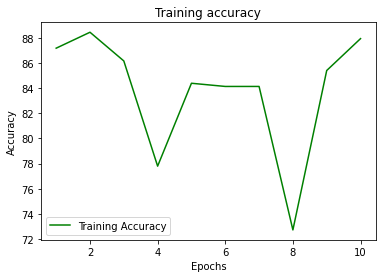

In [41]:
import matplotlib.pyplot as plt
epoch_lst=range(1,11)
plt.plot(epoch_lst, accuracy_lst, 'g', label='Training Accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

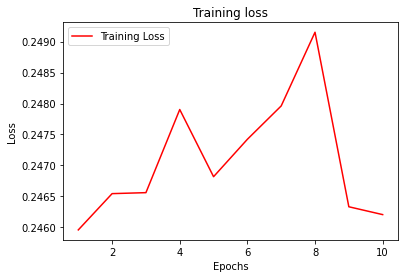

In [42]:
import matplotlib.pyplot as plt
epoch_lst=range(1,11)
plt.plot(epoch_lst, loss_lst, 'r', label='Training Loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
%%time
batches=100
number_of_testing_data=(len(testset)/testloader.__len__())*batches
correct = 0

model_quantized.train(False)
i=0
with torch.no_grad():
    for inputs,labels in testloader:
        if i ==batches: break
        out = model_quantized(inputs).cpu()
        out = torch.argmax(out,dim=1)
        acc = (out==labels).sum().item()
        correct += acc
        i+=1
print(f"Test accuracy: {correct*850/number_of_testing_data}%")

Test accuracy: 89.01115%
CPU times: user 3min 40s, sys: 1.13 s, total: 3min 41s
Wall time: 3min 45s
